# CyRK - SciPy Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import njit

### Create a differential equation to test

In [2]:
initial_conds = np.asarray((20., 20.), dtype=np.complex128)
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

@njit
def diffeq(t, y, dy):
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]


# Create helper function for scipy to work with this kind of diffeq
@njit
def diffeq_scipy(t, y):
    
    dy = np.zeros_like(y)
    diffeq(t, y, dy)
    
    return dy


# Create plotting routine
def diff_plot(t, y, fig_name=None):
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(t, y[0], 'r', label='$y_{0}$')
    ax.plot(t, y[1], 'b', label='$y_{1}$')
    ax.set(xlabel='$t$', ylabel='$y$')
    ax.legend(loc='best')
    
    # Show figure
    plt.show()
    
    # Save figure
    if fig_name is not None:
        fig.savefig(f'{fig_name}.pdf')

### Check results

SciPy Solution


C:\ProgramData\Anaconda3\envs\cyrkdev\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


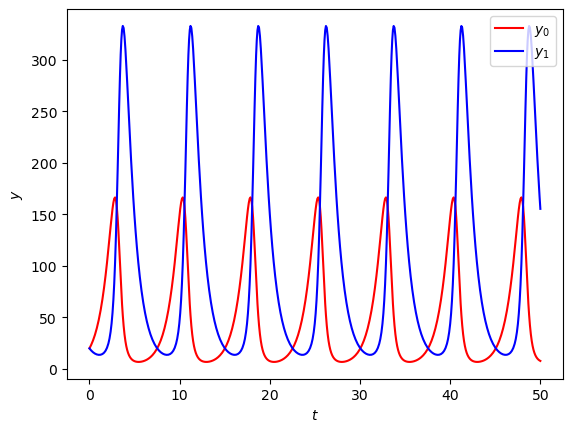

In [3]:
# Scipy
scipy_solution = solve_ivp(diffeq_scipy, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol)
print('SciPy Solution')
diff_plot(scipy_solution.t, scipy_solution.y, fig_name='SciPy')

CyRK (numba) Solution


C:\ProgramData\Anaconda3\envs\cyrkdev\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


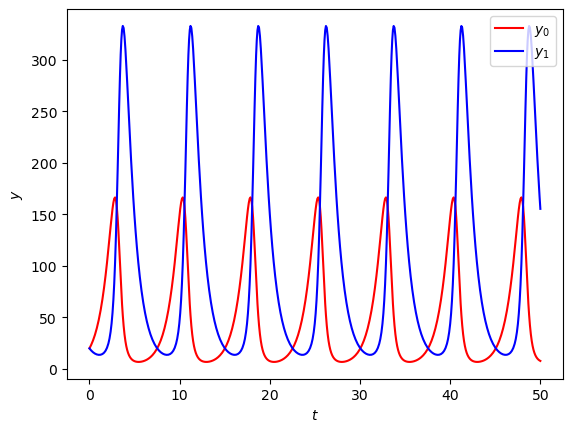

In [4]:
# CyRK - numba implementation
from CyRK import nbrk_ode
time_domain_nb, y_results_nb, success_nb, message_nb = \
    nbrk_ode(diffeq_scipy, time_span, initial_conds, rk_method=1, rtol=rtol, atol=atol)
print('CyRK (numba) Solution')
diff_plot(time_domain_nb, y_results_nb, fig_name='CyRK_numba')

CyRK (numba) Solution


C:\ProgramData\Anaconda3\envs\cyrkdev\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


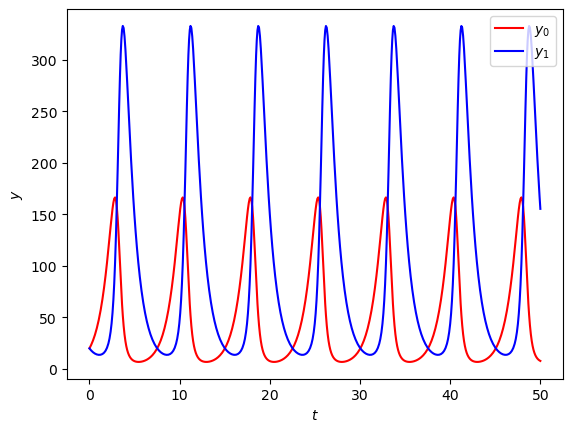

In [5]:
from CyRK import cyrk_ode
time_domain, y_results, success, message = cyrk_ode(diffeq, time_span, initial_conds,
                                                    rk_method=1, rtol=rtol, atol=atol)
print('CyRK (numba) Solution')
diff_plot(time_domain, y_results, fig_name='CyRK_cython')

### Check Performance

In [6]:
# Define Helper Functions
def scipy_run(rtol, atol, time_span):
    out = solve_ivp(diffeq_scipy, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol)

def nbrk_run(rtol, atol, time_span):
    out = nbrk_ode(diffeq_scipy, time_span, initial_conds, rk_method=1, rtol=rtol, atol=atol)
    
def cyrk_run(rtol, atol, time_span):
    out = cyrk_ode(diffeq, time_span, initial_conds, rk_method=1, rtol=rtol, atol=atol)

In [7]:
print('This can take a while...\n')
# Run Results
# rtols = np.logspace(-3, -13, 11)
# end_times = np.logspace(-2, 4, 7)
end_times = np.logspace(-2, 3, 6)

sci_times = list()
nb_times = list()
cy_times = list()

for end_time in end_times:
    
    time_s = (0., end_time)
    
    print(f'Working on end_time = {end_time:0.1e}.')
    result_sci = %timeit -r3 -q -o scipy_run(1.0e-6, 1.0e-8, time_s)
    sci_times.append(result_sci.average)
    print('\tFinished SciPy.')
    result_nb = %timeit -r3 -q -o nbrk_run(1.0e-6, 1.0e-8, time_s)
    nb_times.append(result_nb.average)
    print('\tFinished CyRK Numba.')
    result_cy = %timeit -r3 -q -o cyrk_run(1.0e-6, 1.0e-8, time_s)
    cy_times.append(result_cy.average)
    print('\tFinished CyRK Cython.')
    
print('Done!')

This can take a while...

Working on end_time = 1.0e-02.
	Finished SciPy.
	Finished CyRK Numba.
	Finished CyRK Cython.
Working on end_time = 1.0e-01.
	Finished SciPy.
	Finished CyRK Numba.
	Finished CyRK Cython.
Working on end_time = 1.0e+00.
	Finished SciPy.
	Finished CyRK Numba.
	Finished CyRK Cython.
Working on end_time = 1.0e+01.
	Finished SciPy.
	Finished CyRK Numba.
	Finished CyRK Cython.
Working on end_time = 1.0e+02.
	Finished SciPy.
	Finished CyRK Numba.
	Finished CyRK Cython.
Working on end_time = 1.0e+03.
	Finished SciPy.
	Finished CyRK Numba.
	Finished CyRK Cython.
Done!


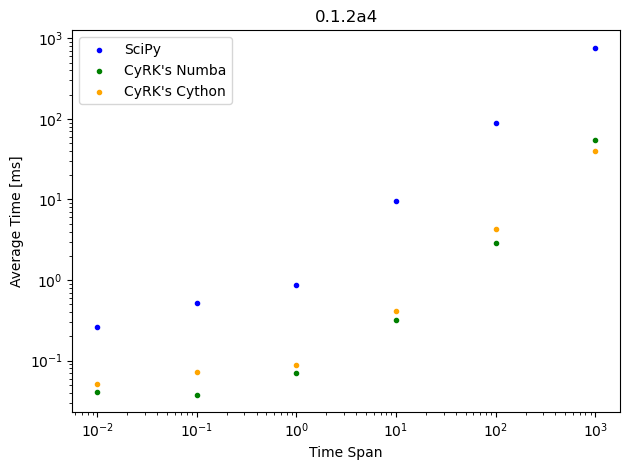

In [8]:
from CyRK import version

version_filesafe = version.replace('.', '-')

# Plot Results
sci_times = np.asarray(sci_times)
nb_times = np.asarray(nb_times)
cy_times = np.asarray(cy_times)

fig, ax = plt.subplots()

ax.scatter(end_times, sci_times*1000, c='blue', label='SciPy', marker='.')
ax.scatter(end_times, nb_times*1000, c='green', label="CyRK's Numba", marker='.')
ax.scatter(end_times, cy_times*1000, c='orange', label="CyRK's Cython", marker='.')

ax.set(ylabel='Average Time [ms]', xlabel='Time Span', xscale='log', yscale='log',
       title=f'CyRK v{version} vs. SciPy')
# ax.set_xlim(ax.get_xlim()[::-1])

ax.legend(loc='best')
ax.set(title=f'{version}')
fig.tight_layout()
fig.savefig(f'CyRK_SciPy_Compare_v{version_filesafe}.png')
plt.show()

In [9]:
# Print Differences
for end_time, sci, nb, cy in zip(end_times, sci_times, nb_times, cy_times):
    
    nb_perc_diff = sci / nb
    cy_perc_diff = sci / cy
    print(f'end_time-{end_time:0.1e}: Numba={nb_perc_diff:0.3f}x; Cython={cy_perc_diff:0.3f}x')

end_time-1.0e-02: Numba=6.371x; Cython=5.158x
end_time-1.0e-01: Numba=13.694x; Cython=7.133x
end_time-1.0e+00: Numba=12.387x; Cython=9.870x
end_time-1.0e+01: Numba=29.916x; Cython=23.015x
end_time-1.0e+02: Numba=30.653x; Cython=20.684x
end_time-1.0e+03: Numba=13.794x; Cython=19.256x


### Memory Usage

In [10]:
%load_ext memory_profiler

ModuleNotFoundError: No module named 'memory_profiler'

In [ ]:
%memit scipy_run(1.0e-6, 1.0e-8, (0., 10000.))

In [ ]:
%memit nbrk_run(1.0e-6, 1.0e-8, (0., 10000.))

In [ ]:
%memit cyrk_run(1.0e-6, 1.0e-8, (0., 10000.))